# Imports and settings

In [28]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D, Lambda, Dropout, InputLayer, Input
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

In [29]:
# settings
IMG_SIZE = (300,300,3)
BATCH_SIZE = 32
EPOCHS = 100

In [30]:
labels_df = pd.read_csv('data/labels.csv')
train_dir = 'data/train'
test_dir = 'data/test'

In [31]:
unique_labels = np.unique(labels_df['breed'])
N_CLASSES = len(unique_labels)

# useful functions

In [32]:
def all_images_to_numpy_array(data_dir,labels_df,image_size=(200,200,3)):
    """
    Loads all the images from a directory to one numpy array
    :param data_dir: directory
    :param image_size: wanted image size
    :return: 
    """
    unique_labels = np.unique(labels_df['breed'])
    data_size = len(os.listdir(data_dir))
    X = np.zeros((data_size,image_size[0],image_size[1],image_size[2]),dtype=np.uint8)
    y = np.zeros((data_size,120),dtype=np.uint8)
    i = 0
    
    for filename in tqdm(os.listdir(data_dir)):
        # load image
        img_path = os.path.join(data_dir,filename)
        image = load_img(img_path,target_size=image_size)
        X[i] = image
        
        # load label
        label = labels_df.loc[labels_df.id == filename[:-4]] # find breed by filename
        y[i] = unique_labels == label['breed'].values[0] # hot encode
        
        i+=1
        
    return X,y

def load_only_images(data_dir,image_size=(200,200,3)):
    """
    Loads all the images from a directory to one numpy array
    :param data_dir: directory
    :param image_size: wanted image size
    :return:
    """
    data_size = len(os.listdir(data_dir))
    X = np.zeros((data_size,image_size[0],image_size[1],image_size[2]),dtype=np.uint8)
    i = 0
    for filename in tqdm(os.listdir(data_dir)):
        img_path = os.path.join(data_dir,filename)
        image = load_img(img_path,target_size=image_size)
        X[i] = image
        i+=1
    return X

def show_25_images(images, labels):
    """
    Displays a plot of 25 images and their labels from a data batch.
    """
    
    # Setup the figure
    plt.figure(figsize=(10, 10))
    for i in range(25):
        
        # Create subplots (5 rows, 5 columns)
        ax = plt.subplot(5, 5, i+1)
        
        # Display an image
        plt.imshow(images[i])
        
        # Add the image label as the title
        plt.title(unique_labels[labels[i].argmax()])
        
        # Turn the grid lines off
        plt.tight_layout()
        plt.axis("off")

# load data

In [33]:
X,y = all_images_to_numpy_array(train_dir,labels_df,IMG_SIZE)
X_test = load_only_images(test_dir,IMG_SIZE)

100%|██████████| 10357/10357 [00:08<00:00, 1167.32it/s]


# Example images

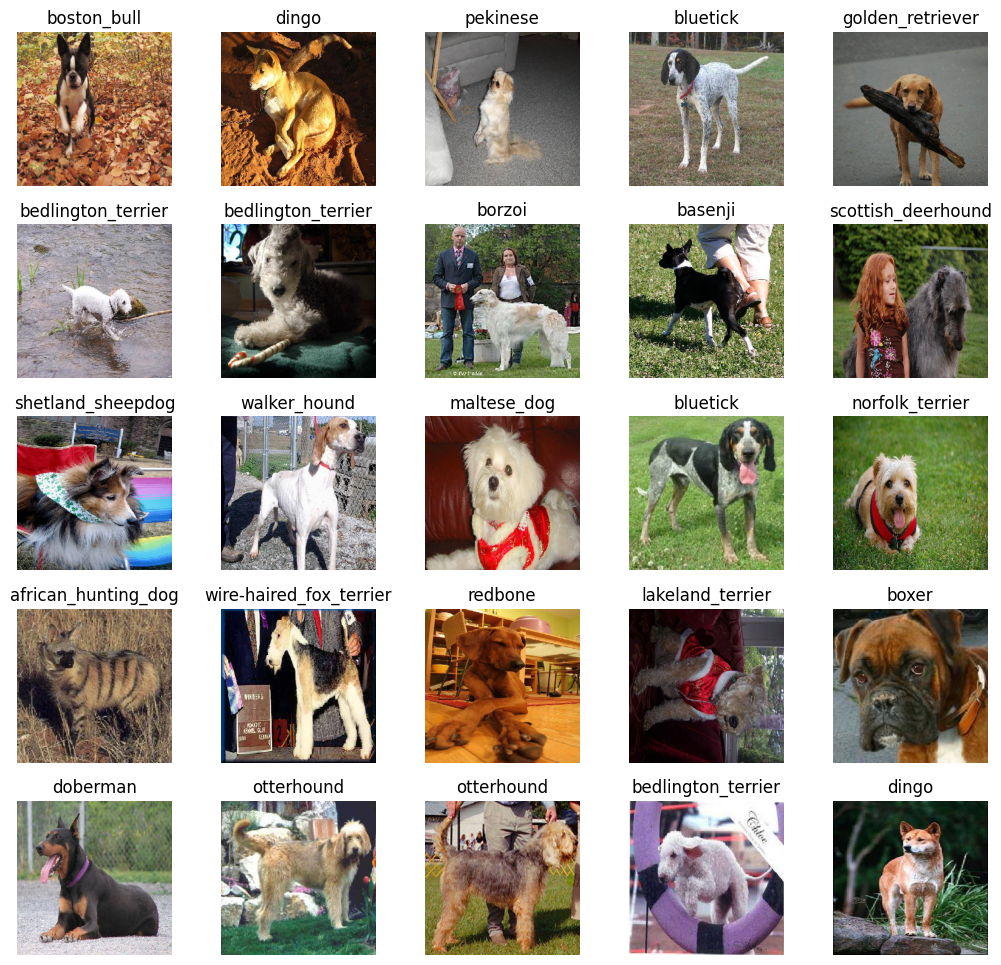

In [34]:
show_25_images(X,y)

# Short Analysis of data distribution

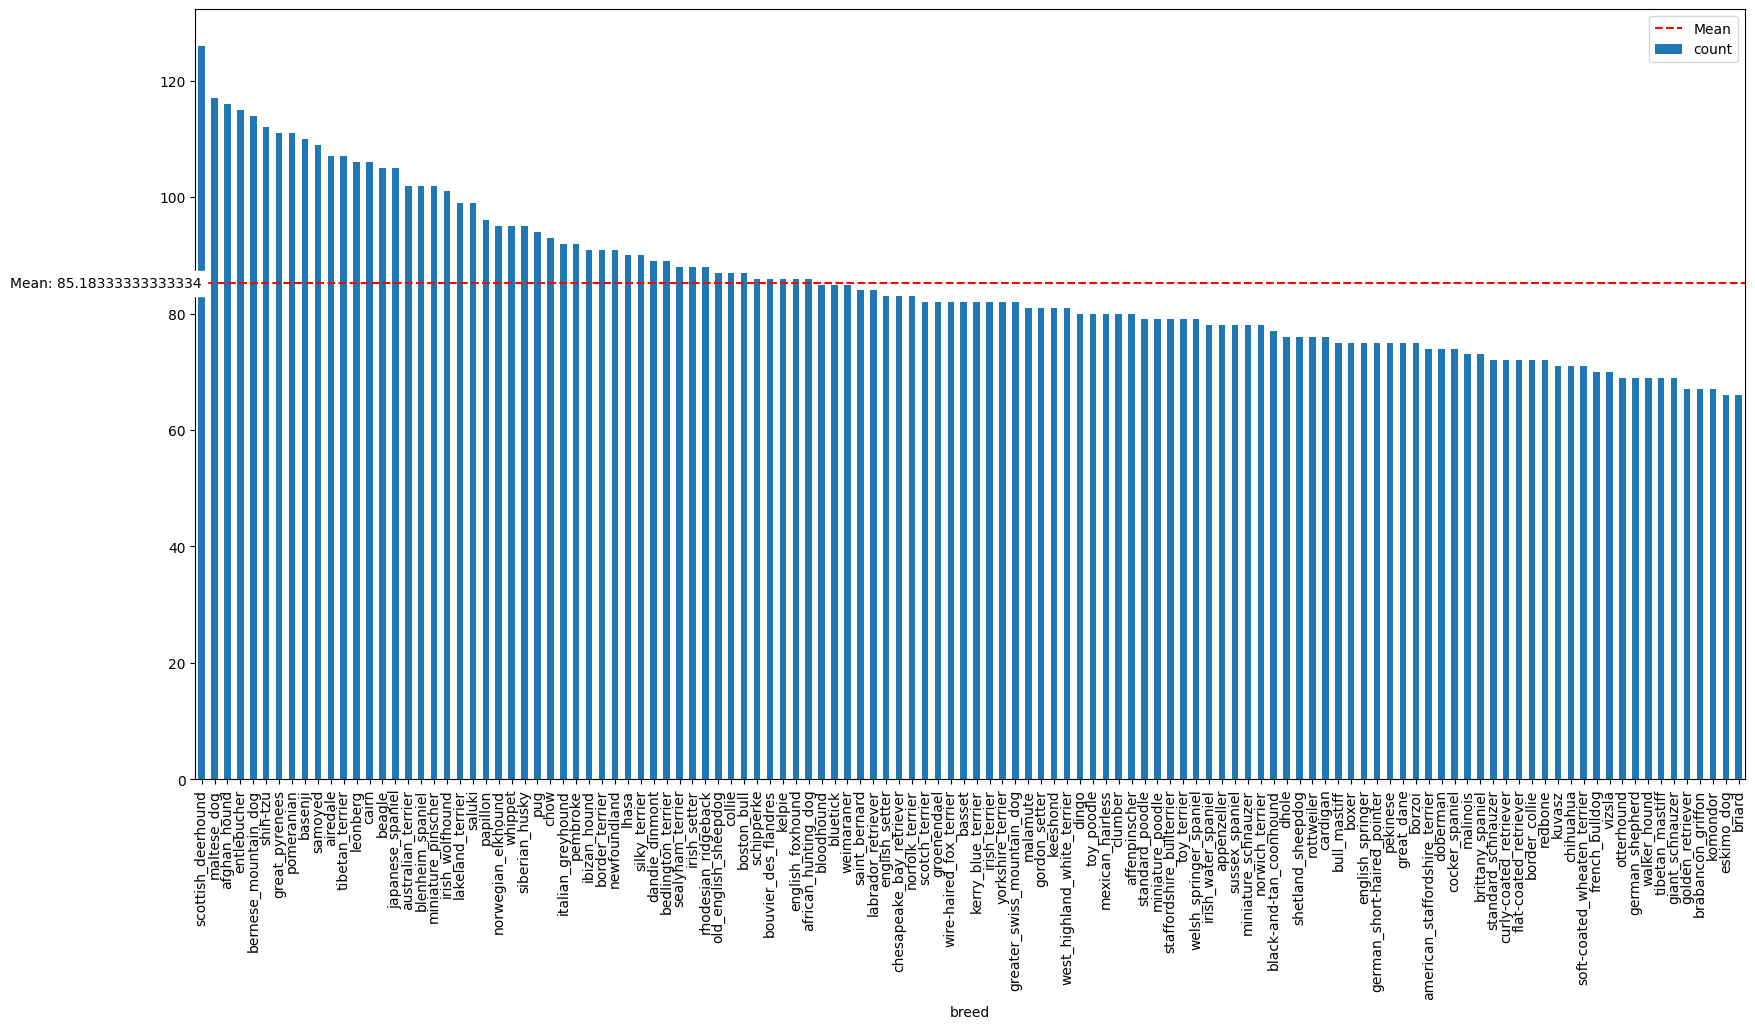

In [35]:
# Bar plot of values for the 'breed' column
labels_df["breed"].value_counts().plot.bar(figsize=(20, 10))

# Calculate the mean value
mean_value = labels_df["breed"].value_counts().mean()

# Plot the mean line
plt.axhline(y=mean_value, color='r', linestyle='--', label='Mean')

# Add a label to the mean line
plt.text(0, mean_value, f'Mean: {mean_value}', va='center', ha='right', backgroundcolor='w')

# Add a legend
plt.legend()

# Display the plot
plt.show()


# Model

## feature extraction

In [36]:
def get_features(model_name, data_preprocessor, input_size, data):
    '''
    1- Create a feature extractor to extract features from the data.
    2- Returns the extracted features and the feature extractor.
    '''
    #Prepare pipeline.
    input_layer = Input(input_size)
    preprocessor = Lambda(data_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    #Extract feature.
    feature_maps = feature_extractor.predict(data, batch_size=64, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps


In [37]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_pi
from keras.applications.xception import Xception, preprocess_input as xception_pi
from keras.applications.nasnet import NASNetLarge, preprocess_input as nasnet_pi
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input as inception_resnet_pi

def get_feature_map(X,img_size):
    inception_features = get_features(InceptionV3, inception_pi, img_size, X)
    xception_features = get_features(Xception, xception_pi, img_size, X)
    nasnet_features = get_features(NASNetLarge, nasnet_pi, img_size, X)
    inc_resnet_features = get_features(InceptionResNetV2, inception_resnet_pi, img_size, X)

    features = np.concatenate([inception_features,
                               xception_features,
                               nasnet_features,
                               inc_resnet_features],axis=-1)
    return features

In [38]:
final_features = get_feature_map(X,IMG_SIZE)

160/160 [==============================] - 12s 74ms/step
Feature maps shape:  (10222, 2048)
160/160 [==============================] - 19s 117ms/step
Feature maps shape:  (10222, 2048)
160/160 [==============================] - 59s 351ms/step
Feature maps shape:  (10222, 4032)
160/160 [==============================] - 30s 176ms/step
Feature maps shape:  (10222, 1536)


## DNN model

In [39]:
from keras.callbacks import EarlyStopping
#Prepare call backs
EarlyStop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
my_callback=[EarlyStop_callback]

In [40]:
#Prepare DNN model
dnn = keras.models.Sequential([
    InputLayer(final_features.shape[1:]),
    Dropout(0.65),
    Dense(N_CLASSES, activation='softmax')
])

dnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

#Train simple DNN on extracted features.
h = dnn.fit(final_features, y,
            batch_size=128,
            epochs=60,
            validation_split=0.1,
            callbacks=my_callback)

Epoch 1/60
72/72 [==============================] - 1s 9ms/step - loss: 0.8261 - accuracy: 0.8235 - val_loss: 0.2137 - val_accuracy: 0.9335
Epoch 2/60
72/72 [==============================] - 0s 3ms/step - loss: 0.1894 - accuracy: 0.9385 - val_loss: 0.2226 - val_accuracy: 0.9335
Epoch 3/60
72/72 [==============================] - 0s 3ms/step - loss: 0.1446 - accuracy: 0.9539 - val_loss: 0.2147 - val_accuracy: 0.9394
Epoch 4/60
72/72 [==============================] - 0s 2ms/step - loss: 0.1203 - accuracy: 0.9588 - val_loss: 0.2304 - val_accuracy: 0.9384
Epoch 5/60
72/72 [==============================] - 0s 3ms/step - loss: 0.0950 - accuracy: 0.9665 - val_loss: 0.2312 - val_accuracy: 0.9374
Epoch 6/60
72/72 [==============================] - 0s 3ms/step - loss: 0.0837 - accuracy: 0.9705 - val_loss: 0.2170 - val_accuracy: 0.9365
Epoch 7/60
72/72 [==============================] - 0s 3ms/step - loss: 0.0666 - accuracy: 0.9768 - val_loss: 0.2162 - val_accuracy: 0.9374
Epoch 8/60
72/72 [==

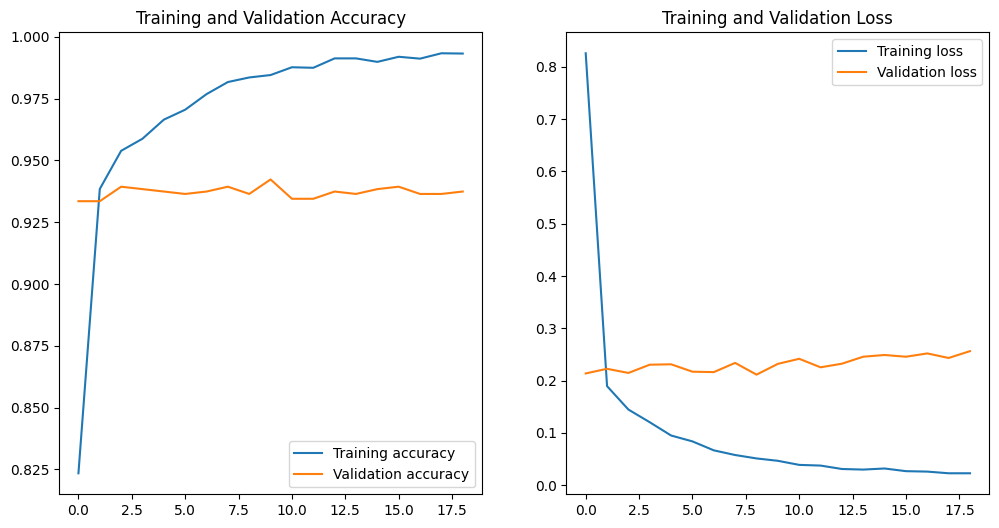

In [41]:
def plot_history(history):
    """
    Plots the loss function of a model
    :param history: 
    :return: 
    """
    epochs = len(history.history['accuracy'])
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(epochs_range,acc,label='Training accuracy')
    plt.plot(epochs_range,val_acc,label='Validation accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1,2,2)
    plt.plot(epochs_range,loss,label='Training loss')
    plt.plot(epochs_range,val_loss,label='Validation loss')
    plt.legend()
    plt.title('Training and Validation Loss')
plot_history(h)

In [42]:
dnn.save('dog_breed_classifier.h5')

# Predictions

In [43]:
test_features_25 = get_feature_map(X_test[:25],IMG_SIZE)

1/1 [==============================] - 1s 905ms/step
Feature maps shape:  (25, 2048)
1/1 [==============================] - 0s 385ms/step
Feature maps shape:  (25, 2048)
1/1 [==============================] - 3s 3s/step
Feature maps shape:  (25, 4032)
1/1 [==============================] - 2s 2s/step
Feature maps shape:  (25, 1536)


In [44]:
test_labels_25 = dnn.predict(test_features_25)

1/1 [==============================] - 0s 26ms/step


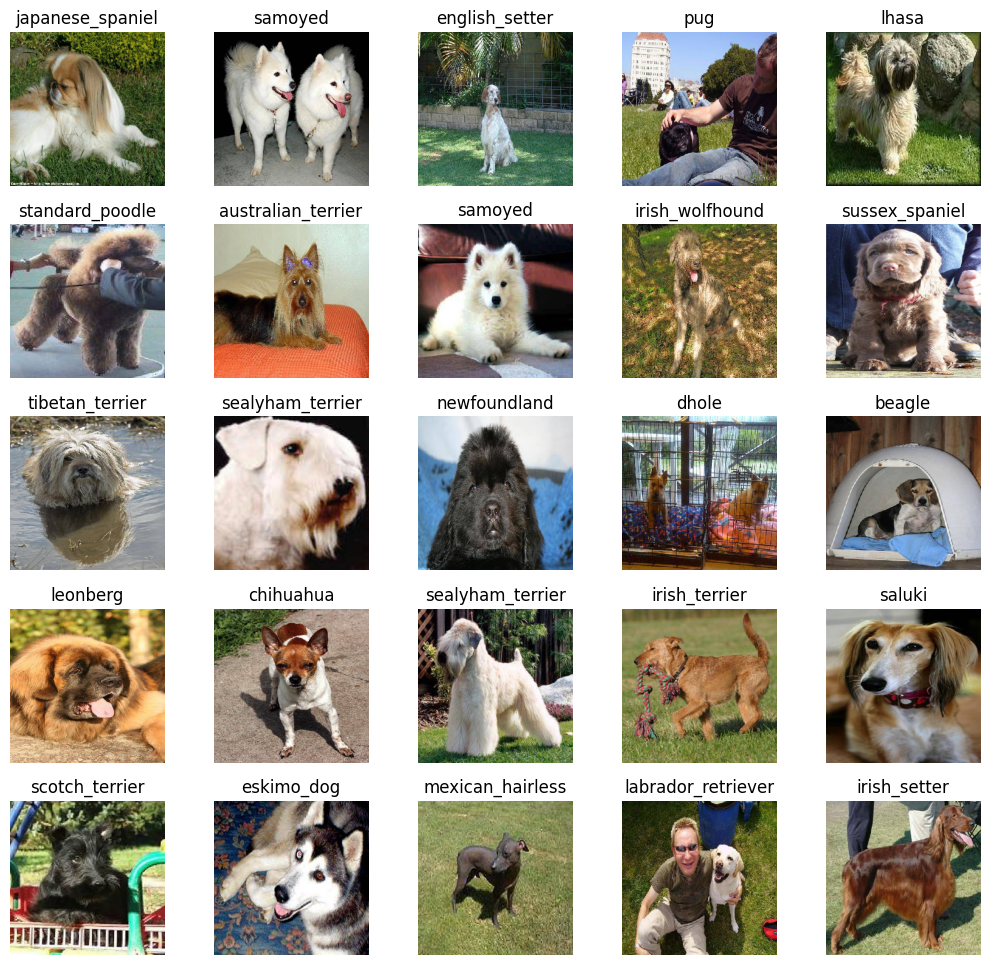

In [45]:
show_25_images(X_test[:25],test_labels_25)

# Conclusion
Model is about ~94% accurate, so it seems pretty good for me.
topics covered : 
Image classification, 
feature extraction, 
transfer learning,
deep neural networks